<a href="https://colab.research.google.com/github/graviraja/100-Days-of-NLP/blob/applications%2Fclustering/applications/clustering/20newsgroup/Improved%20Topic%20Identification%20in%20News%20using%20LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Installations

In [1]:
!pip install pyldavis -q

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 79kB/s 


In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Imports

In [69]:
import re
import spacy
import numpy as np
import pandas as pd

from nltk.corpus import stopwords

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import scipy.sparse
from pprint import pprint

import pyLDAvis
import pyLDAvis.gensim
import pyLDAvis.sklearn

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS

In [4]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
np.random.seed(42)

In [5]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

nlp = spacy.load('en', disable=['parser', 'ner'])

### 20 Newsgroup Dataset

In [6]:
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df.head()

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [7]:
df.target_names.unique()

array(['rec.autos', 'comp.sys.mac.hardware', 'comp.graphics', 'sci.space',
       'talk.politics.guns', 'sci.med', 'comp.sys.ibm.pc.hardware',
       'comp.os.ms-windows.misc', 'rec.motorcycles', 'talk.religion.misc',
       'misc.forsale', 'alt.atheism', 'sci.electronics', 'comp.windows.x',
       'rec.sport.hockey', 'rec.sport.baseball', 'soc.religion.christian',
       'talk.politics.mideast', 'talk.politics.misc', 'sci.crypt'],
      dtype=object)

In [8]:
len(df)

11314

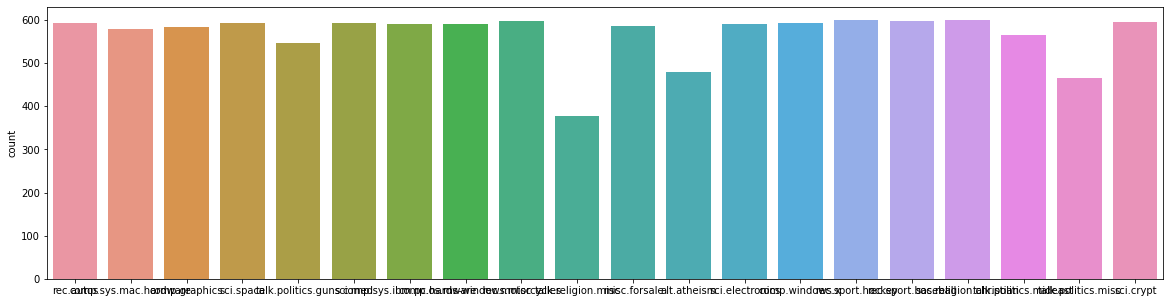

In [ ]:
plt.figure(figsize=(20, 5))
sns.countplot(df.target_names.values)

In [9]:
data = df.content.values

### Tokenization

In [10]:
def sentence_to_tokens(sent):
    # remove emails
    sent = re.sub(r'\S*@\S*\s?', '', sent)
    # remove newline chars
    sent = re.sub(r'\s+', ' ', sent)
    # remove single quotes
    sent = re.sub(r"\'", "", sent)
    # converts to lower case tokens and removes tokens that are
    # too small & too long. Also remove accent characters & punct
    tokens = simple_preprocess(str(sent), deacc=True)
    return tokens

In [11]:
%%time
tokenized_data = [sentence_to_tokens(doc) for doc in data]

CPU times: user 8.94 s, sys: 223 ms, total: 9.16 s
Wall time: 9.17 s


In [12]:
tokenized_data[0]

['from',
 'wheres',
 'my',
 'thing',
 'subject',
 'what',
 'car',
 'is',
 'this',
 'nntp',
 'posting',
 'host',
 'rac',
 'wam',
 'umd',
 'edu',
 'organization',
 'university',
 'of',
 'maryland',
 'college',
 'park',
 'lines',
 'was',
 'wondering',
 'if',
 'anyone',
 'out',
 'there',
 'could',
 'enlighten',
 'me',
 'on',
 'this',
 'car',
 'saw',
 'the',
 'other',
 'day',
 'it',
 'was',
 'door',
 'sports',
 'car',
 'looked',
 'to',
 'be',
 'from',
 'the',
 'late',
 'early',
 'it',
 'was',
 'called',
 'bricklin',
 'the',
 'doors',
 'were',
 'really',
 'small',
 'in',
 'addition',
 'the',
 'front',
 'bumper',
 'was',
 'separate',
 'from',
 'the',
 'rest',
 'of',
 'the',
 'body',
 'this',
 'is',
 'all',
 'know',
 'if',
 'anyone',
 'can',
 'tellme',
 'model',
 'name',
 'engine',
 'specs',
 'years',
 'of',
 'production',
 'where',
 'this',
 'car',
 'is',
 'made',
 'history',
 'or',
 'whatever',
 'info',
 'you',
 'have',
 'on',
 'this',
 'funky',
 'looking',
 'car',
 'please',
 'mail',
 'than

### Pre-processing

In [13]:
%%time
# create bigrams from the tokenized data
bigram = gensim.models.Phrases(tokenized_data, threshold=50)
# make a bigram model
bigram_mod = gensim.models.phrases.Phraser(bigram)

CPU times: user 14 s, sys: 129 ms, total: 14.1 s
Wall time: 14.1 s


In [20]:
def process_words(texts, allowed_postags=["NOUN", "ADJ", "VERB", "ADV"]):
    # remove stopwords
    stop_free = [[word for word in doc if word not in stop_words] for doc in texts]
    # bigrams
    bigram_data = [bigram_mod[doc] for doc in stop_free]

    texts_out = []
    for sent in bigram_data:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]  
    # join words into sentence in-order to make it useful to tfidf processing
    texts_out = [" ".join(words) for words in texts_out]
    return texts_out

In [21]:
%%time
processed_data = process_words(tokenized_data)

CPU times: user 1min 39s, sys: 1.66 s, total: 1min 41s
Wall time: 1min 41s


In [22]:
processed_data[0]

'thing car nntp_posting host_rac park line wonder could enlighten car see day door look late early call bricklin door really small addition separate rest body know tellme model name engine year production car make history info funky look car mail thank bring neighborhood lerxst'

### Tfidf

In [83]:
tfidf = TfidfVectorizer(analyzer='word', min_df=10, stop_words='english', lowercase=True, token_pattern='[a-zA-Z0-9]{3,}')

data_vectorized = tfidf.fit_transform(processed_data)

### LDA Model

In [84]:
%%time
lda_model = LatentDirichletAllocation(
    n_components=20,
    max_iter=10,
    n_jobs=-1,
    random_state=42
)

lda_output = lda_model.fit_transform(data_vectorized)

CPU times: user 1.31 s, sys: 252 ms, total: 1.57 s
Wall time: 43.6 s


In [85]:
# higher the better
print(f"Log Likelihood: {lda_model.score(data_vectorized)}")

# lower the better
print(f"preplexity: {lda_model.perplexity(data_vectorized)}")

Log Likelihood: -614818.8527289848
preplexity: 17764.162720178756


### Grid Search

In [86]:
search_params = {
    "n_components": [10, 15, 20, 25],
    "learning_decay": [.5, .7, .9]
}

In [87]:
%%time

lda = LatentDirichletAllocation()

model = GridSearchCV(lda, param_grid=search_params)

model.fit(data_vectorized)

CPU times: user 30min 9s, sys: 15min 35s, total: 45min 44s
Wall time: 27min 3s


### Best LDA Model

In [112]:
best_lda_model = model.best_estimator_

print(f"Best Log likelihood Score: {model.best_score_}")

print(f"Best Perplexity: {best_lda_model.perplexity(data_vectorized)}")

Best Log likelihood Score: -134938.04082723527
Best Perplexity: 9366.99450246799


In [113]:
model.best_params_

{'learning_decay': 0.9, 'n_components': 10}

### Visualization of Topics

In [91]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, tfidf, mds='tsne')
vis

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
9      32.420952   8.115230       1        1  21.224662
3       0.648955  71.707100       2        1  20.221915
7      71.019684   9.971006       3        1  19.929311
0       3.785981  33.185135       4        1  19.599572
8     -42.666500  -9.222070       5        1   5.666369
1      -3.621689 -43.526516       6        1   4.175069
4      -3.632402  -4.171708       7        1   4.048840
6     -36.584400  35.804413       8        1   1.734551
5      44.391380  50.615383       9        1   1.731770
2      40.235809 -31.591665      10        1   1.667941, topic_info=               Term        Freq       Total Category  logprob  loglift
3294            key   87.000000   87.000000  Default  30.0000  30.0000
5206           sale   76.000000   76.000000  Default  29.0000  29.0000
6578         window  126.000000  126.000000  Default  28.0000  28.0000
2526           game   98.000000   98.000000  Default  27.0000  27.0000
953            chip   74.000000   74.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
5802   substantiate    1.811182    3.700551  Topic10  -6.3607   3.3791
2655       greeting    2.288621    9.205668  Topic10  -6.1267   2.7017
4240  participation    1.886446    4.352186  Topic10  -6.3200   3.2576
886            cent    1.939179    5.468829  Topic10  -6.2924   3.0568
2599      glutamate    1.910693    5.329005  Topic10  -6.3072   3.0679

[621 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
19       10  0.817896  abstinence
31        1  0.157269      accept
31        2  0.629077      accept
31        3  0.078635      accept
31        4  0.104846      accept
...     ...       ...         ...
6660      4  0.458373        year
6660      5  0.016083        year
6660      6  0.016083        year
6660      7  0.072375        year
6663      7  0.891962       yeast

[1447 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 8, 1, 9, 2, 5, 7, 6, 3])

### Topic's keyword distribution

In [94]:
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# topic keyword matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# columns are the words
df_topic_keywords.columns = tfidf.get_feature_names()

# rows are the topics
df_topic_keywords.index = topicnames

df_topic_keywords.head()

,aaa,aaron,abandon,abbreviation,abide,ability,able,abolish,abomination,abort,abortion,abridge,abroad,abs,absence,absent,absolute,absolutely,absorb,abstinence,abstract,absurd,absurdity,abundant,abuse,abusive,academia,academic,accelerate,acceleration,accelerator,accept,acceptable,acceptance,access,accessible,accessory,accident,accidental,accidentally,...,wreck,wrist,write,writer,writing,wrong,wrongful,wwii,xaw,ximage,xlib,xor,xputimage,xserver,xview,xwindow,xxdate,yank,yard,yea,year,yearly,years,yeast,yell,yellow,yesterday,yield,young,youngster,yourselfer,youth,ysu,yup,zinc,zionism,zionist,zip,zone,zoom
Topic0,1.037152,0.658276,0.886788,1.050146,0.100000,4.538552,15.757559,0.100173,0.100175,0.100045,1.323026,0.100048,0.10001,0.242367,0.100327,0.947405,1.297948,4.620009,1.258422,0.100035,1.790189,2.870439,0.928604,0.100007,0.100148,0.109532,0.100156,0.874582,0.606446,3.810870,0.790557,4.097218,0.830402,1.600077,2.869542,0.101013,0.100024,0.100211,0.378732,0.100006,...,0.100132,1.590176,76.411650,2.604536,0.100491,9.082246,0.100000,0.100003,0.100007,0.417998,0.100000,0.100004,2.110277,0.1,0.100002,0.100000,2.189750,2.602344,2.501892,0.580849,65.126044,0.100832,5.047384,0.100023,0.752272,2.264979,6.457405,1.594343,9.481675,1.377965,0.100046,0.126346,0.100002,0.993116,0.116352,0.100000,0.100000,0.100016,2.491403,0.100857
Topic1,0.100320,0.100000,0.100006,1.012255,0.100000,0.100003,0.448317,0.100000,0.100000,0.100007,0.100000,0.100003,0.10000,1.046931,0.100000,0.100000,0.100012,0.100629,0.100000,0.100000,0.100002,0.100319,0.100000,0.100000,0.100031,0.100000,0.100000,0.100026,1.040636,0.100017,0.100003,0.967537,0.100023,0.100000,0.898988,0.100143,2.016639,0.476314,0.100201,0.100034,...,0.100007,0.100010,5.519261,0.166943,0.100001,1.138284,0.100000,0.100000,2.454211,2.925215,0.100049,0.100003,2.016543,0.1,0.100003,2.804196,0.255497,0.100000,0.100043,0.222709,2.069438,0.100000,0.100185,0.100000,0.100011,1.964773,0.100015,0.476917,0.100006,0.100000,1.285586,0.100000,0.100002,0.100021,0.100054,0.100000,0.100000,0.425740,0.100000,0.483675
Topic2,0.100000,0.100000,0.100005,0.100000,0.100000,0.100002,0.100006,0.100000,0.100000,0.100000,0.100014,0.100000,0.10000,0.100000,0.100000,0.100000,0.100000,0.100001,0.100000,3.109366,0.100000,0.100001,0.100015,0.100000,0.100014,0.100002,0.100001,0.100000,0.100000,0.100000,0.100000,0.100063,0.100000,0.100010,0.100001,0.100000,0.100000,0.100000,0.144744,0.100000,...,0.432913,0.100000,0.177186,0.100000,0.100006,0.100004,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.1,0.100000,0.907959,0.100000,0.100000,0.100000,0.100000,0.100004,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100000,0.100002,0.100000,0.100000,0.100013,0.100000,0.100000,0.100000,0.100000,0.100000
Topic3,0.103632,1.376530,1.676865,0.100804,0.100139,5.836542,9.586604,0.103965,1.196036,0.100009,7.392333,0.100158,0.16344,0.100032,2.721259,0.956199,11.248083,5.682379,0.168835,0.100487,1.164499,3.088893,1.582831,0.977828,5.988851,0.881626,0.259435,1.222041,0.100018,0.100001,0.100009,25.961151,3.591759,1.214104,2.620046,0.293823,0.100004,0.100040,0.100481,0.100019,...,0.100167,0.100000,82.761779,5.252241,6.050084,24.887887,0.388949,1.502056,0.100001,0.100001,0.100000,0.100040,0.100000,0.1,0.100000,0.100002,0.100003,0.100000,0.100006,0.773614,18.322979,0.100007,2.687325,0.100014,2.201476,0.100079,0.100043,0.100066,5.570229,0.173495,0.100403,0.100105,0.100000,0.404389,0.100684,6.482925,2.534011,0.100341,0.100045,0.100001
Topic4,1.434790,0.100000,0.100002,0.100004,0.100002,0.707565,0.110377,1.320790,0.100003,0.100000,0.153473,0.100000,0.10000,0.100070,0.100041,0.100019,0.100004,0.100012,0.100003,0.100001,0.100070,0.100012,0.100002,0.100009,0.285200,0.100010,0.483935,1.936966,0.100001,0.100000,0.100000,0.171095,0.100009,0.100010,0.142757,0.100354,0.100000,0.757243,0.100001,0.100000,...,0.200085,1.098327,15.835570,0.762012,0.302856,3.048823,0.100000,0.100008,0.100014,0.100003,0.100000,0.100000,0.10

### Top 15 keywords in each topic

In [114]:
def top_words(vectorizer=tfidf, lda_model=lda_model, n_words=15):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = top_words(vectorizer=tfidf, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_top_keywords = pd.DataFrame(topic_keywords)
df_topic_top_keywords.columns = ['Word '+str(i) for i in range(df_topic_top_keywords.shape[1])]
df_topic_top_keywords.index = ['Topic '+str(i) for i in range(df_topic_top_keywords.shape[0])]
df_topic_top_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,line,game,write,team,player,article,year,play,know,good,think,host,time,make,say
Topic 1,sale,line,offer,battery,sell,shipping,voltage,audio,output,signal,power,wire,input,thank,amp
Topic 2,needle,jagr,copyright,abstinence,passion,manuscript,activate,kermit,andrew,pregnancy,masse,qwk,birthday,molitor,chant
Topic 3,people,say,write,think,believe,article,know,make,line,law,religion,right,mean,claim,question
Topic 4,game,win,write,lose,line,baseball,team,article,hit,run,phillie,year,fan,homosexual,good
Topic 5,nickname,vinyl,cocaine,cigarette,squid,bobby,reporting,trunk,diff,instinctive,prism,lsd,dale,tad,mozumder
Topic 6,captain,uniform,trade,logo,wallpaper,wheelie,shaft,bmp,bake,retard,loan,outbreak,allocation,mercury,micro
Topic 7,car,write,article,bike,gun,line,people,say,kill,think,make,time,know,thing,ride
Topic 8,key,clipper,chip,encryption,phone,government,tap,secure,write,encrypt,line,security,escrow,privacy,secret
Topic 9,line,window,thank,file,card,know,problem,host,program,help,need,drive,work,mail,write


### Predicting topic of a sentence

In [115]:
best_lda_model

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.9,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [124]:
def predict_topic(text):
    tokens = [sentence_to_tokens(text)]
    processed_tokens = process_words(tokens)
    tfidf_tokens = tfidf.transform(processed_tokens)

    topic_scores = best_lda_model.transform(tfidf_tokens)
    topic = np.argmax(topic_scores)
    topic_score = topic_scores[0][topic]
    topic_keywords = df_topic_top_keywords.iloc[topic, :].values.tolist()
    return topic, topic_score, topic_keywords

In [126]:
# Predict the topic
mytext = "I believe in christianity and like the bible"
topic, prob_scores, words = predict_topic(text = mytext)
print(topic)
print(prob_scores)
print(words)


3
0.5499716895590633
['people', 'say', 'write', 'think', 'believe', 'article', 'know', 'make', 'line', 'law', 'religion', 'right', 'mean', 'claim', 'question']
